Get the Ogbn_arxiv dataset and set the graph in the right format

# ogbn-arxiv

https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv

https://paperswithcode.com/sota/node-property-prediction-on-ogbn-arxiv

Directed

Nodes: 169,343

Edges: 1,166,243

128-dimensional feature for each node

Metric: Accuracy

Descargar los datos, ponerlos en formato correcto de networkx. Procesar los datos para que esten listos para clasificacion de subjects con el modelo propuesto

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import nltk
import pandas as pd
import seaborn as sns
import torch
from ogb.nodeproppred import PygNodePropPredDataset

## Descargar

In [2]:
# carpeta deonde descargar los datos crudos de pyg
data_folder = '.\\Data'

In [3]:
# descargar los datos 
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root = data_folder)

In [4]:
# tomar indices de train, val, test
split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

# tomar el grafo
graph = dataset[0] 

# ver que es dirigido
print(graph.is_directed())
graph

True


Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])

## Convertir a Networkx

In [5]:
# inicar grafo dirigido vacio
G = nx.DiGraph()

# ---------------------------------------------
# poner nodos con sus features y su label

# features y labels
node_features = graph.x.numpy()
node_labels = graph.y.numpy().T.reshape(-1)

# por cada nodo
for v in range(graph.num_nodes):
    
    # ponerlo junto con su vector y su label
    G.add_node(v, vector = node_features[v], label = node_labels[v])
    
# ---------------------------------------------
# poner nodos con sus features
aristas = graph.edge_index.numpy().T

# añadir
for edge in aristas:
    
    # poner
    G.add_edge(edge[0], edge[1])
    
# ----------------------------------------------
# añadir la division de cada nodo (train, val, test)

# iterar en los nodos
for v, info_v in G.nodes(data=True):
    
    # definir el estado de v de acuerod a su pertencencia
    
    # ver a donde pertenece
    if v in train_idx:
        estado_v = "train"
        
    elif v in valid_idx:
        estado_v = "val"
    
    elif v in test_idx:
        estado_v = "test"
                
    # si de casualidad no es de ninguna (deberia ser de alguna)
    else:
        raise ExceptionType(f"{v} no pertenece a ninguna division")

    # poner la division como argumento
    info_v['division'] = estado_v

In [6]:
# ver un nodo
G.nodes[4]

{'vector': array([-0.071154,  0.070766, -0.281432, -0.161892, -0.165246, -0.029116,
        -0.338593, -0.138727,  0.100015,  0.132794, -0.126174, -0.407558,
         0.149886,  0.057895, -0.139899,  0.053791,  0.109652,  0.391524,
        -0.001939, -0.162602, -0.205013,  0.256068, -0.258416,  0.058886,
        -0.26759 ,  0.415948,  0.125211, -0.493177, -0.040566, -0.085627,
        -0.060162,  0.14019 , -0.019309,  0.039385, -0.021147, -0.243197,
        -0.007809, -0.049747, -0.087419,  0.274257,  0.278649, -0.205997,
         0.259502, -0.286165,  0.26308 ,  0.081598,  0.324728, -0.117321,
         0.395589,  0.162376,  0.419938,  0.134742, -0.060884, -0.160168,
        -0.164697,  0.03116 , -0.129867, -0.124779,  0.108197, -0.043775,
         0.487988,  0.146426,  0.046491, -0.11286 ,  0.015692,  0.381787,
        -0.168857,  0.100727,  0.536781, -0.506546,  0.002513, -0.268712,
         0.119366, -0.190317, -0.17789 , -0.293866,  0.178358,  0.064656,
         0.076797, -0.240739

## Leer los textos

In [7]:
# previamente se descargaron de:
# https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv

import gzip

file_path = data_folder + '/titleabs.tsv.gz'

# Lista para almacenar los datos extraídos
papers = []

# Leer y procesar el archivo línea por línea
with gzip.open(file_path, 'rt', encoding='utf-8', errors='replace') as f:
    for idx, line in enumerate(f):
        # Separar la línea en partes, asumiendo que la primera parte es el ID
        parts = line.strip().split('\t', 1)
        
        if len(parts) < 2:
            continue  # Ignorar líneas que no tengan al menos dos partes

        paper_id = parts[0].strip()
        # la primera linea tiene id que no se lee bien
        if idx == 0:
            paper_id = 200971
        
        title_abstract = parts[1].strip()

        # Intentar dividir title y abstract
        if '	' in title_abstract:
            title, abstract = title_abstract.split('	', 1)
        else:
            # Si no hay un segundo tabulador, asumir que no hay abstract
            title = title_abstract
            abstract = ""

        # Almacenar el ID, título y abstract
        papers.append({
            'ID': paper_id,
            'Title': title,
            'Abstract': abstract
        })

df = pd.DataFrame(papers)
df.head()

,ID,Title,Abstract
0,200971,ontology as a source for rule generation,This paper discloses the potential of OWL (Web...
1,549074,a novel methodology for thermal analysis a 3 d...,The semiconductor industry is reaching a fasci...
2,630234,spreadsheets on the move an evaluation of mobi...,The power of mobile devices has increased dram...
3,803423,multi view metric learning for multi view vide...,Traditional methods on video summarization are...
4,1102481,big data analytics in future internet of things,Current research on Internet of Things (IoT) m...


In [8]:
# ahora leer el maping de nodos
file_path = data_folder + '/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz'


# Leer y procesar el archivo línea por línea
with gzip.open(file_path, 'rt', encoding='utf-8', errors='replace') as f:
    
    mapping_df = pd.read_csv(f)
    
# poner como str
mapping_df['paper id'] = mapping_df['paper id'].astype(str)
mapping_df['node idx'] = mapping_df['node idx'].astype(str)

mapping_df.head()

,node idx,paper id
0,0,9657784
1,1,39886162
2,2,116214155
3,3,121432379
4,4,231147053


In [9]:
# ver info
paper_id_grafo = set(x for x in mapping_df['paper id'].values)
print(len(paper_id_grafo))

paper_id_disponible = set(x for x in df['ID'].values)
print(len(paper_id_disponible))

# contencion
paper_id_grafo.issubset(paper_id_disponible)

169343
179719


True

In [10]:
# hacer un diccionario de maping
mapping_dict = dict(zip(mapping_df['node idx'], mapping_df['paper id']))
print(mapping_dict['4'])

# hacer el inverso
mapping_inverso = {value: key for key, value in mapping_dict.items()}
print(mapping_inverso['231147053'])

231147053
4


In [11]:
# limitar los textos a solo nodos que importan
df = df[df['ID'].isin(paper_id_grafo)].copy()
print(df.shape)

# poner el node id en ese df
df['node_id'] = df['ID'].apply(lambda x: mapping_inverso[x])
df['node_id'] = df['node_id'].astype(int)
df = df.sort_values('node_id')
df = df.set_index('node_id')

df.head()

(169343, 3)


,ID,Title,Abstract
node_id,,,
0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes..."
1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...
2,116214155,on the absence of the rip in real world applic...,The purpose of this paper is twofold. The firs...
3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...
4,231147053,analysis of asymptotically optimal sampling ba...,Over the last 20 years significant effort has ...


In [12]:
# añadir el texto de cada nodo
from tqdm import tqdm

# iterar en las filas
for idx, row in tqdm(df.iterrows()):
    
    # get info
    title = row['Title']
    abstract = row['Abstract']
    
    # set atributes
    G.nodes[idx]['title'] = title
    G.nodes[idx]['abstract'] = abstract
    G.nodes[idx]['t_y_a'] = f"{title} {abstract}"

169343it [00:11, 14552.59it/s]


In [13]:
# quitar vectores
for v, info_v in G.nodes(data=True):
    del info_v["vector"]

In [14]:
# ver un nodos
G.nodes[4]

{'label': 27,
 'division': 'train',
 'title': 'analysis of asymptotically optimal sampling based motion planning algorithms for lipschitz continuous dynamical systems',
 'abstract': "Over the last 20 years significant effort has been dedicated to the development of sampling-based motion planning algorithms such as the Rapidly-exploring Random Trees (RRT) and its asymptotically optimal version (e.g. RRT*). However, asymptotic optimality for RRT* only holds for linear and fully actuated systems or for a small number of non-linear systems (e.g. Dubin's car) for which a steering function is available. The purpose of this paper is to show that asymptotically optimal motion planning for dynamical systems with differential constraints can be achieved without the use of a steering function. We develop a novel analysis on sampling-based planning algorithms that sample the control space. This analysis demonstrated that asymptotically optimal path planning for any Lipschitz continuous dynamical s

## Exploracion del grafo


In [15]:
# basico
num_nodos = G.number_of_nodes()
num_aristas = G.number_of_edges()

print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")

Se tienen 169343 nodos
Se tienen 1166243 aristas


In [16]:
# obtener una lista de los grados
lista_grados = np.array([G.degree(node) for node in G.nodes])

# grados mayor y menor
grado_max = lista_grados.max()
grado_min = lista_grados.min()

grado_promedio = lista_grados.mean()

# imprimir
print(f"El grado maximo es: {grado_max}")
print(f"El grado minimo es: {grado_min}")
print(f"El grado promedio es: {grado_promedio}")

El grado maximo es: 13161
El grado minimo es: 1
El grado promedio es: 13.77373732601879


In [17]:
# ver out degree

lista_grados_out = np.array([G.out_degree(node) for node in G.nodes])

# grados mayor y menor
grado_max_out = lista_grados_out.max()
grado_min_out = lista_grados_out.min()

grado_promedio_out = lista_grados_out.mean()

# imprimir
print(f"El grado maximo de salida es: {grado_max_out}")
print(f"El grado minimo de sallida es: {grado_min_out}")
print(f"El grado promedio de salida es: {grado_promedio_out}")

El grado maximo de salida es: 436
El grado minimo de sallida es: 0
El grado promedio de salida es: 6.886868663009395


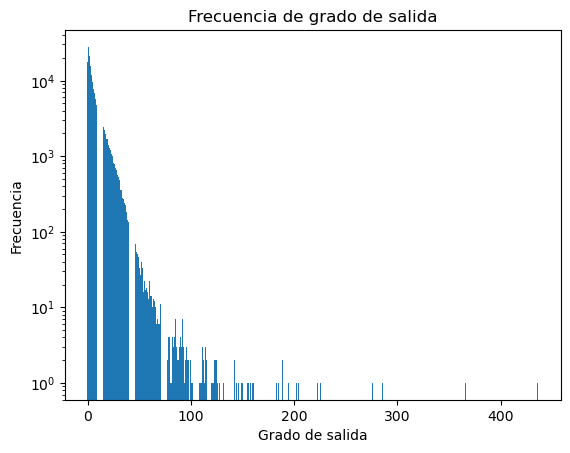

In [18]:
# sacar frecuencias
frecuencias_grados_out = nltk.FreqDist(lista_grados_out)

# tomar lss tamaños y las frecuencias
grados_out, frecuencias = zip(*frecuencias_grados_out.items())

# hacer la grafica
plt.bar(grados_out, frecuencias)
plt.xlabel("Grado de salida")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de grado de salida")
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.show()

In [19]:
# ver para cuantos es 0
n0_num_nodos_out_grado_0 = sum(lista_grados_out==0)

# ver el porcentaje
print(f"El {round(100*n0_num_nodos_out_grado_0/len(lista_grados_out), 2)}% de los nodos tiene grado de salida 0")

El 10.3% de los nodos tiene grado de salida 0


In [20]:
# ver in degree
lista_grados_in = np.array([G.in_degree(node) for node in G.nodes])

# grados mayor y menor
grado_max_in = lista_grados_in.max()
grado_min_in = lista_grados_in.min()

grado_promedio_in = lista_grados_in.mean()

# imprimir
print(f"El grado maximo de entrada es: {grado_max_in}")
print(f"El grado minimo de entrada es: {grado_min_in}")
print(f"El grado promedio de entrada es: {grado_promedio_in}")

El grado maximo de entrada es: 13155
El grado minimo de entrada es: 0
El grado promedio de entrada es: 6.886868663009395


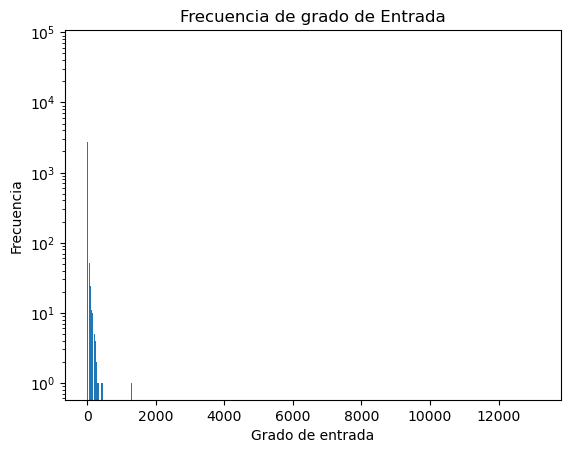

In [21]:
# sacar frecuencias
frecuencias_grados_in = nltk.FreqDist(lista_grados_in)

# tomar lss tamaños y las frecuencias
grados_in, frecuencias = zip(*frecuencias_grados_in.items())

# hacer la grafica
plt.bar(grados_in, frecuencias)
plt.xlabel("Grado de entrada")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de grado de Entrada")
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.show()

In [22]:
# ver para cuantos es 0
n0_num_nodos_in_grado_0 = sum(lista_grados_in==0)

# ver el porcentaje
print(f"El {round(100*n0_num_nodos_in_grado_0/len(lista_grados_in), 2)}% de los nodos tiene grado de entrada 0")

El 36.62% de los nodos tiene grado de entrada 0


In [23]:
# nodos aislados
nodos_aislados = list(nx.isolates(G))
num_nodos_aislados = len(nodos_aislados)

# componentes debilemente conectados
# es decir, conectados si quitas direcion
num_componentes = nx.number_weakly_connected_components(G)

print("Número de nodos aislados:", num_nodos_aislados)
print("Número de componentes conectadas:", num_componentes)

Número de nodos aislados: 0
Número de componentes conectadas: 1


## Ver etiquetas

In [24]:
# hacer un df con nodos, etiquietas y division
df = pd.DataFrame()
df['nodo'] = [v for v in G.nodes()]
df['y'] = [info_v["label"] for v, info_v in G.nodes(data=True)]
df['division'] = [info_v["division"] for v, info_v in G.nodes(data=True)]

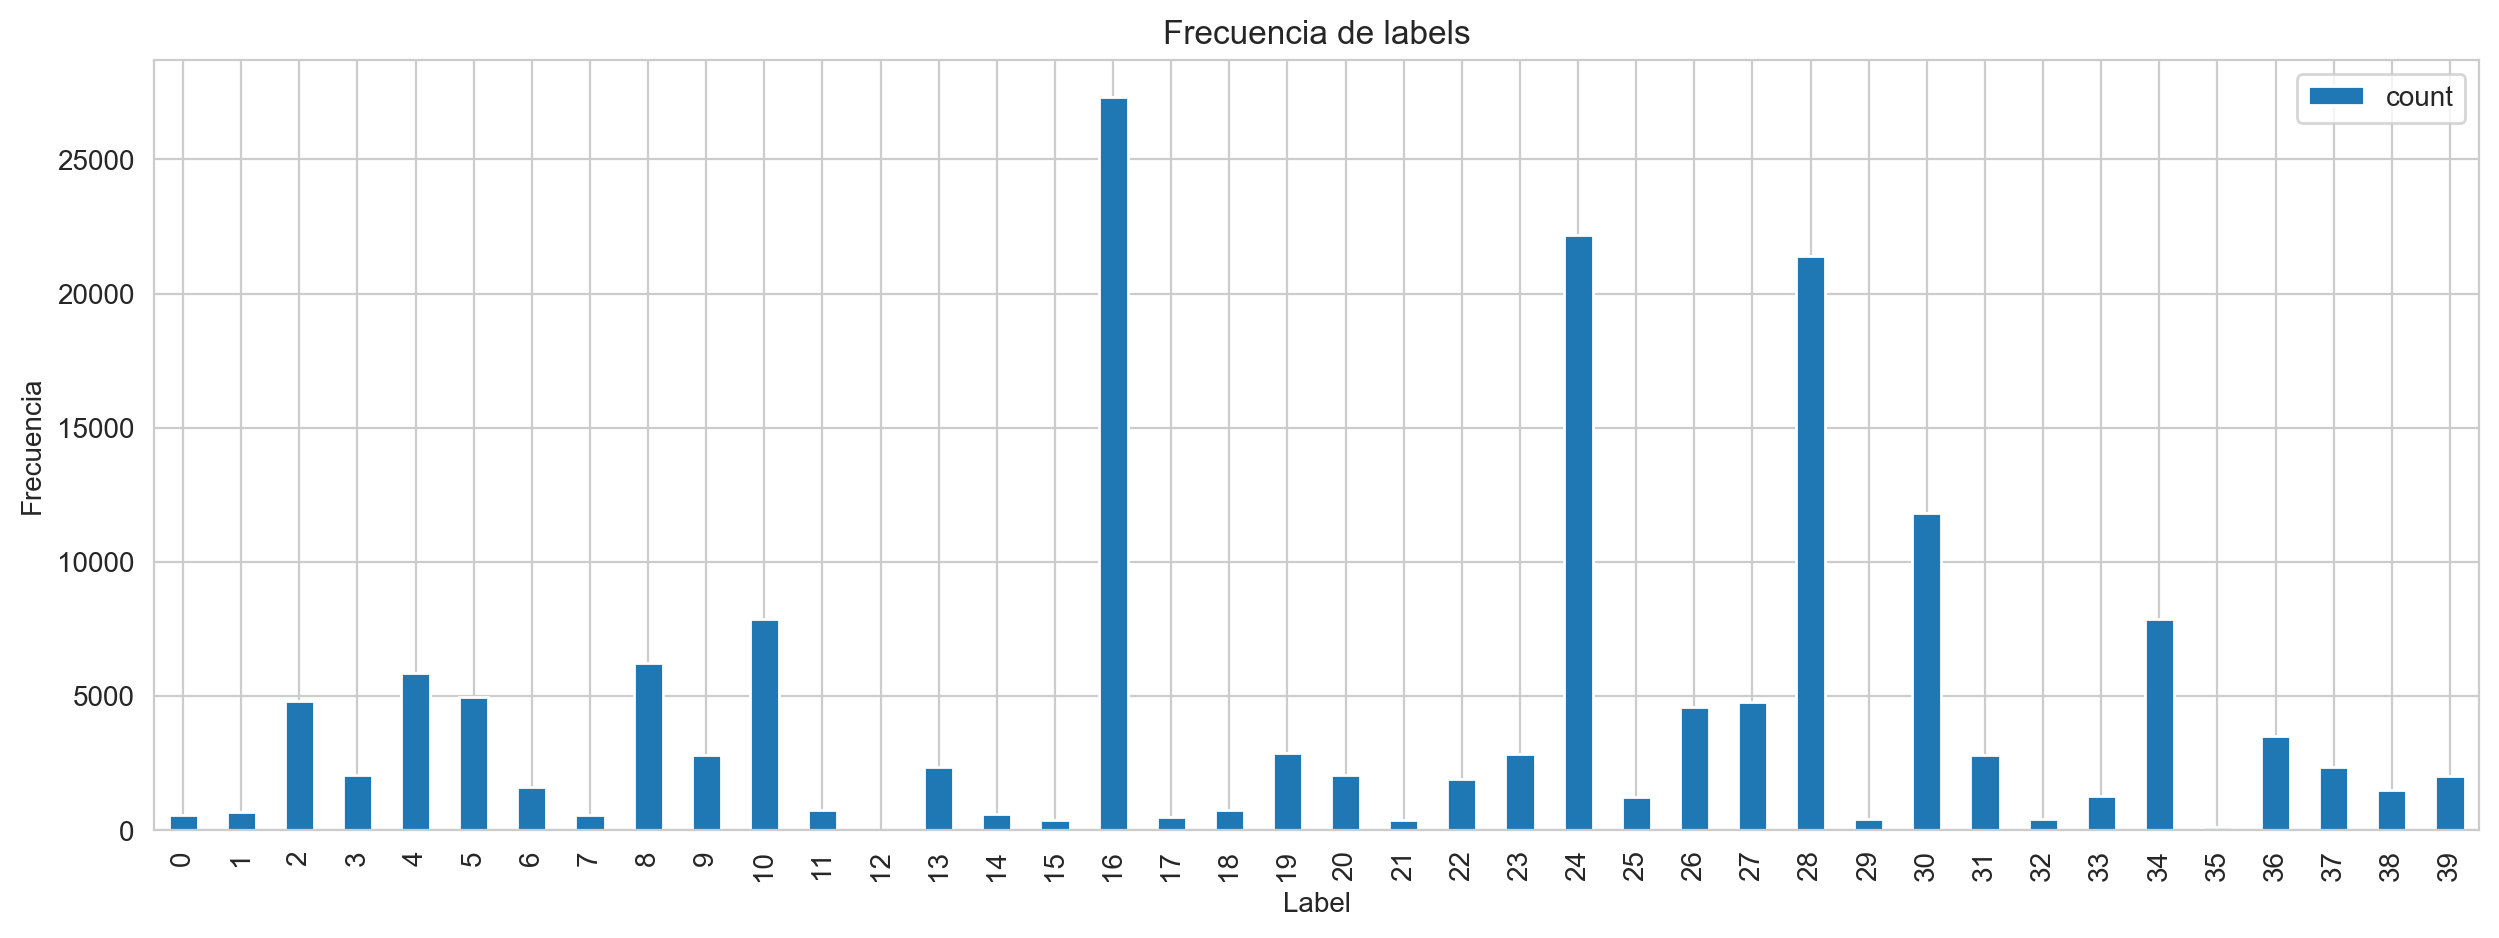

In [25]:
sns.set_style("whitegrid")

# hacer la figura de distribucion de etiquetas
fig, ax = plt.subplots(figsize=(15, 5), dpi = 200)

# pasar como pivot table
pivot_df = df.pivot_table(index='y', aggfunc='size').reset_index(name='count').set_index("y")
# hacer las barras
pivot_df.plot(kind='bar', ax=ax)

# titulos
ax.set_title('Frecuencia de labels')
ax.set_xlabel('Label')
ax.set_ylabel('Frecuencia')

plt.show()

In [26]:
# cuantos nodos por cada division
len_train = len(train_idx)
len_val = len(valid_idx)
len_test = len(test_idx)

# porcentajes
perc_train = 100*len_train/graph.num_nodes
perc_val = 100*len_val/graph.num_nodes
perc_test = 100*len_test/graph.num_nodes

# indicar
print("Numero de nodos:")
print(f"Train: {len_train}")
print(f"Val:   {len_val}")
print(f"Test:  {len_test}")
print(f"\nPorcentajes:")
print(f"Train: {round(perc_train, 1)}%")
print(f"Val:   {round(perc_val, 1)}%")
print(f"Test:  {round(perc_test, 1)}%")

Numero de nodos:
Train: 90941
Val:   29799
Test:  48603

Porcentajes:
Train: 53.7%
Val:   17.6%
Test:  28.7%


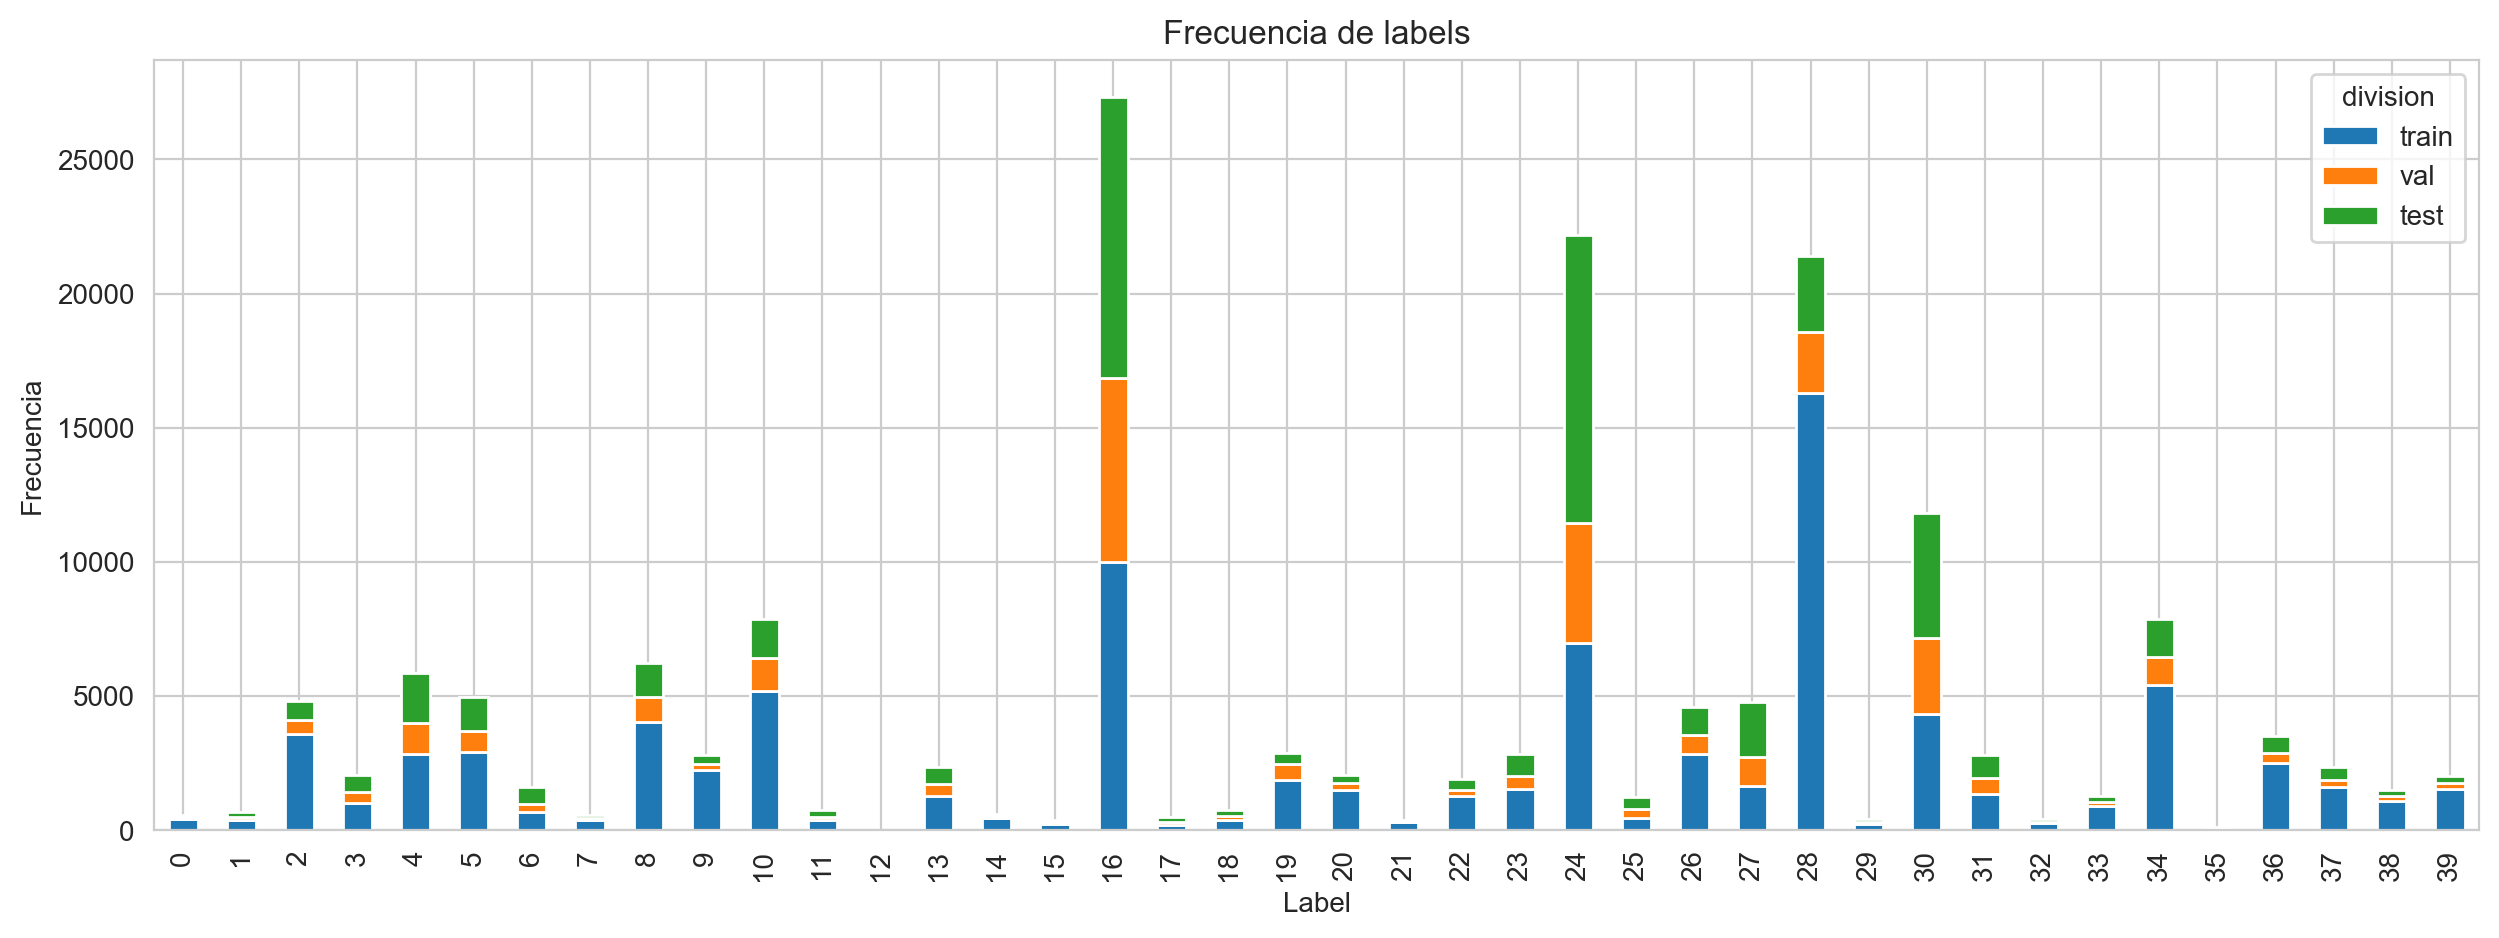

In [27]:
sns.set_style("whitegrid")

# hacer la figura de distribucion de etiquetas
fig, ax = plt.subplots(figsize=(15, 5), dpi = 200)

# pasar como pivot table
pivot_df = df.pivot_table(index='y', columns = 'division', aggfunc='size')
# ordenar
pivot_df = pivot_df[["train", "val", "test"]]
# hacer las barras
pivot_df.plot(kind='bar', ax=ax, stacked= True)

# titulos
ax.set_title('Frecuencia de labels')
ax.set_xlabel('Label')
ax.set_ylabel('Frecuencia')

plt.show()

## Guardar grafo de networkx 

In [28]:
# guardar el grafo
with open(data_folder + "/graph_nx.json", 'wb') as f:
    pickle.dump(G, f)

In [29]:
# ejemplo de cargar grafo 
with open(data_folder + "/graph_nx.json", 'rb') as f:
    grafo_cargado = pickle.load(f)

num_nodos = grafo_cargado.number_of_nodes()
num_aristas = grafo_cargado.number_of_edges()

print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")  

Se tienen 169343 nodos
Se tienen 1166243 aristas
